# 线性回归和梯度下降

## 准备阶段：生成训练数据和测试数据，选取多元一次的线性关系

In [1]:
# 生成train data和test data
# 随机选择一些x和w，b
from random import randint, uniform
from numpy import random


def genCase(n: int, m: int):
    x = random.uniform(-10, 10, (m, n))
    w = random.uniform(0, 10, (n, 1))
    b = uniform(0, 10)
    # 加入噪音
    y = [sum(x[i1].dot(w)) + b + uniform(-0.5, 0.5) for i1 in range(len(x))]
    print("Generated %d cases with %d features." % (m, n))
    return x, y, w, b


def splitCase(x, y):
    n = len(x)
    if len(y) != n:
        return [], [], [], []
    trainX, trainY, testX, testY = [], [], [], []
    for j in range(n):
        if randint(1, 4) > 2:
            testX.append(x[j])
            testY.append(y[j])
        else:
            trainX.append(x[j])
            trainY.append(y[j])
    print("Split data into 2 parts: %d train data and %d test data" % (len(trainX), len(testX)))
    return trainX, trainY, testX, testY


X, Y, OriginW, OriginB = genCase(10, 1000)
TrainX, TrainY, TestX, TestY = splitCase(X, Y)
# 导出到文件
with open('./data/train.txt', 'w') as f:
    for i in range(len(TrainX)):
        f.write('\t'.join(list(map(str, TrainX[i]))) + '\t' + str(TrainY[i]) + '\n')
with open('./data/test.txt', 'w') as f:
    for i in range(len(TestX)):
        f.write('\t'.join(list(map(str, TestX[i]))) + '\t' + str(TestY[i]) + '\n')

Generated 1000 cases with 10 features.
Split data into 2 parts: 484 train data and 516 test data


## 训练阶段：采用批量梯度下降方法拟合

In [21]:
from numpy import loadtxt, ones


def h(x, w, b):
    return sum(x.dot(w)) + b


def loss(x, y, w, b):
    return sum([(h(x[i1], w, b) - y[i1]) ** 2 for i1 in range(len(x))])


def batchGradientDescent(x, y, rate=0.1, iterBound=100000, gradBound=1e-6):
    m = len(x)
    if m == 0 or len(y) != m:
        return [], -1
    n = len(x[0])
    w, b = ones((n, 1)), 1
    print("Learning ratio: %f" % rate)
    for k in range(iterBound):
        gradW = [sum([x[i][j] * (y[i] - h(x[i], w, b)) for i in range(m)]) / m for j in range(n)]
        gradB = sum([(y[i] - h(x[i], w, b)) for i in range(m)]) / m
        # 跳出循环的条件：梯度值较小
        if abs(gradB) <= gradBound:
            print("Converges after %d rounds of batch gradient descent." % k)
            return w, b
        for i in range(n):
            w[i] += gradW[i] * rate
        b += gradB * rate
    print("After %d rounds of gradient descent, the loss is %f" % (k, loss(x, y, w, b)))
    return w, b


def readData(file: str):
    with open(file, 'r') as f:
        data = loadtxt(f)
    return [data[i1][:-1] for i1 in range(len(data))], [data[i1][-1] for i1 in range(len(data))]


trainX, trainY = readData("./data/train.txt")
testX, testY = readData("./data/test.txt")
%time W, B = batchGradientDescent(trainX, trainY, 0.02)

Learning ratio: 0.020000
Converges after 608 rounds of batch gradient descent.
CPU times: user 5.72 s, sys: 23 ms, total: 5.75 s
Wall time: 5.76 s


## 预测阶段：使用test数据测试模型准确率

In [22]:
print("Loss for test data: %f" % loss(testX, testY, W, B))
print("Loss for test data with original w and b: %f" % loss(testX, testY, OriginW, OriginB))
print("Difference for w and b:", OriginW - W, OriginB - B)

Loss for test data: 47.161984
Loss for test data with original w and b: 46.188546
Difference for w and b: [[-0.00095575]
 [ 0.0001872 ]
 [ 0.00153668]
 [ 0.00050082]
 [-0.00034511]
 [-0.00396764]
 [-0.00295501]
 [ 0.00099687]
 [ 0.00369943]
 [ 0.00379453]] -0.003807025307413836


- 经过梯度下降之后，达到了较好的精度。
- 时间上存在改进空间。

## 使用高次拟合，查看loss变化

In [28]:
def generateAll(x, n):
    if n == 1:
        return x
    res = ones((len(x), n * len(x[0])))
    count = len(x[0])
    for i1 in range(len(x)):
        for j1 in range(n):
            for k1 in range(count):
                res[i1][k1 + j1 * count] = x[i1][k1] ** (j1 + 1)
    return res


# 拟合过程可以直接使用batchGradientDescent函数解决
# 为了节约时间（一方面learning rate不能高，一高就不收敛；另一方面太低可能半小时都跑不出来）
trainLoss = [loss(trainX, trainY, W, B)]
testLoss = [loss(testX, testY, W, B)]
for i in range(2, 6):
    exTrainX, exTestX = generateAll(trainX, i), generateAll(testX, i)
    %time Wi, Bi = batchGradientDescent(exTrainX, trainY, 0.0001 / pow(10, i), 1000)
    trainLoss.append(loss(exTrainX, trainY, Wi, Bi))
    testLoss.append(loss(exTestX, testY, Wi, Bi))

Learning ratio: 0.000001
After 999 rounds of gradient descent, the loss is 2422113.568785
CPU times: user 20.2 s, sys: 64.6 ms, total: 20.2 s
Wall time: 20.3 s
Learning ratio: 0.000000
After 999 rounds of gradient descent, the loss is 5956478.712595
CPU times: user 29.3 s, sys: 46.8 ms, total: 29.4 s
Wall time: 29.4 s
Learning ratio: 0.000000
After 999 rounds of gradient descent, the loss is 39028115.823895
CPU times: user 38.4 s, sys: 59.8 ms, total: 38.5 s
Wall time: 38.5 s
Learning ratio: 0.000000
After 999 rounds of gradient descent, the loss is 27234997.710129
CPU times: user 48.5 s, sys: 156 ms, total: 48.7 s
Wall time: 48.8 s


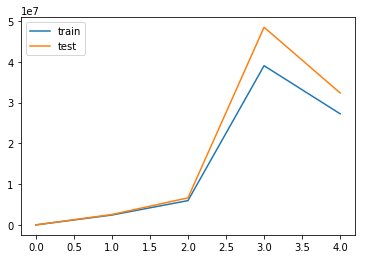

In [33]:
import matplotlib.pyplot as plt
from numpy import arange

x_axis = arange(len(trainLoss))
plt.axis('on')
plt.plot(x_axis, trainLoss, label='train')
plt.plot(x_axis, testLoss, label='test')
plt.legend()
plt.show()

- 为了节约运行时间，限制运行次数在1000次以内；暂时看不出过拟合现象。
- 但是在维度上升的时候，train的loss明显小于test的loss。